In [1]:
import numpy as np

An MDP example with state space $S=\{s_0,s_1,s_2\}$, an action space $A=\{a_0,a_1\}$. The reward functions $R_a(s,s')$ and transition functions $P_a(s,s')$ could be listed as tables.

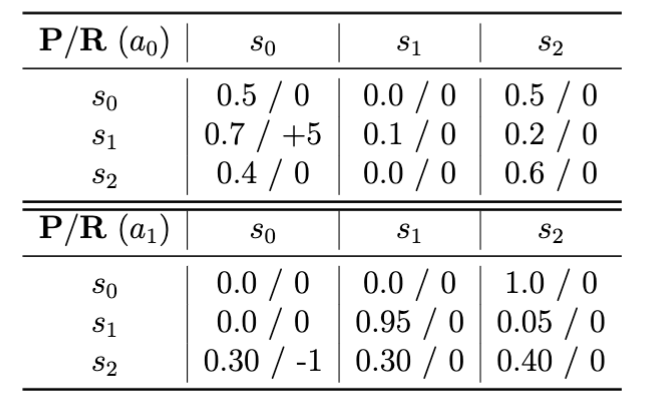

### the transition and reward functions

In [60]:
P0 = np.array([
    [0.5, 0, 0.5],
    [0.7, 0.1, 0.2],
    [0.4, 0, 0.6]])

R0 = np.array([
    [0, 0, 0],
    [5, 0, 0],
    [0, 0, 0]])

P1 = np.array([
    [0, 0, 1],
    [0, 0.95, 0.05],
    [0.3, 0.3, 0.4]])

R1 = np.array([
    [0, 0, 0],
    [0, 0, 0],
    [-1, 0, 0]])

### 1. Value iteration

In [80]:
# initialize the state value function
Q = np.zeros((3,1))
gamma = 0.9

for i in range(10):
    Q0 = (R0 * P0).sum(1).reshape(-1,1) + \
            gamma * (P0 @ Q.reshape(-1, 1))

    Q1 = (R1 * P1).sum(1).reshape(-1,1) + \
            gamma * (P1 @ Q.reshape(-1, 1))

    Q = np.maximum(Q0, Q1)
    Q -= np.mean(Q)
    print (f"--- iter {i} ---")
    print (f"choice: {((Q0 < Q1).flatten())}")
    print (f"Q: {Q.flatten()}")
    print ()

--- iter 0 ---
choice: [False False False]
Q: [-1.16666667  2.33333333 -1.16666667]

--- iter 1 ---
choice: [False False  True]
Q: [-1.48666667  2.32833333 -0.84166667]

--- iter 2 ---
choice: [ True False  True]
Q: [-1.25356667  2.12538333 -0.87181667]

--- iter 3 ---
choice: [ True False  True]
Q: [-1.31180567  2.21743983 -0.90563417]

--- iter 4 ---
choice: [ True False  True]
Q: [-1.3195841   2.20560452 -0.88602042]

--- iter 5 ---
choice: [ True False  True]
Q: [-1.30759256  2.19750857 -0.88991602]

--- iter 6 ---
choice: [ True False  True]
Q: [-1.31185465  2.20287734 -0.89102268]

--- iter 7 ---
choice: [ True False  True]
Q: [-1.31168508  2.20164178 -0.8899567 ]

--- iter 8 ---
choice: [ True False  True]
Q: [-1.31113997  2.20141502 -0.89027504]

--- iter 9 ---
choice: [ True False  True]
Q: [-1.31140999  2.2016972  -0.89028721]



### 2. Policy iteration

In [81]:
# initialize the policy (all choose a0)
Pi = np.array([0, 0, 0])
# initialize state value function randomly
Q = np.random.random((3,1))
gamma = 0.9
    
for i in range(5):
    print (f"--- iter {i} ---")
    
    Q0 = (R0 * P0).sum(1).reshape(-1,1) + \
            gamma * (P0 @ Q.reshape(-1, 1))

    Q1 = (R1 * P1).sum(1).reshape(-1,1) + \
            gamma * (P1 @ Q.reshape(-1, 1))

    # policy evaluation
    Q = Q0 * (1 - Pi).reshape(-1, 1) + Q1 * Pi.reshape(-1, 1) 
    Q -= Q.mean()
    print (f"cur state valie: {Q.flatten()}")
    
    
    Q0 = (R0 * P0).sum(1).reshape(-1,1) + \
            gamma * (P0 @ Q.reshape(-1, 1))

    Q1 = (R1 * P1).sum(1).reshape(-1,1) + \
            gamma * (P1 @ Q.reshape(-1, 1))

    # policy improvement
    Pi = (Q0 < Q1).astype("int").flatten()
    print (f"policy: {Pi}")
    print ()

--- iter 0 ---
cur state valie: [-1.17552657  2.3828844  -1.20735783]
policy: [0 0 1]

--- iter 1 ---
cur state valie: [-1.49749573  2.33135569 -0.83385996]
policy: [1 0 1]

--- iter 2 ---
cur state valie: [-1.24740181  2.11937706 -0.87197525]
policy: [1 0 1]

--- iter 3 ---
cur state valie: [-1.31300097  2.219702   -0.90670102]
policy: [1 0 1]

--- iter 4 ---
cur state valie: [-1.31994504  2.20546226 -0.88551722]
policy: [1 0 1]



### Q-learning

In [50]:
# initialize the Q(s,a) table
Q = np.zeros((10, 2))

alpha = 0.1
gamma = 0.95

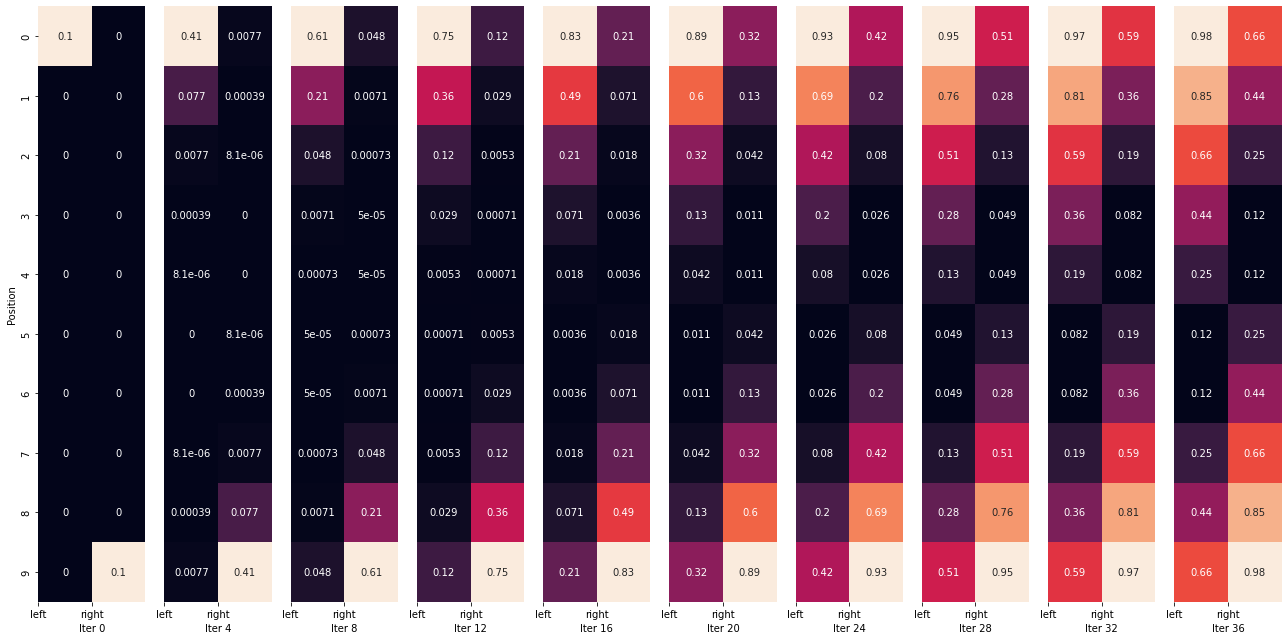

In [51]:
import seaborn as sns

plt.figure(figsize=(18,9))

for i in range(50):
    Q_ = Q.copy()
    for s in range(10):
        for a in range(2):
            if (s == 9) and (a == 1) or (s == 0) and (a == 0):
                Q_[s,a] = Q[s,a] + alpha * (1 - Q[s,a])
            elif (a == 0):
                Q_[s,a] = Q[s,a] + alpha * (0 + gamma * max(Q[s-1,:]) - Q[s,a])
            elif (a == 1):
                Q_[s,a] = Q[s,a] + alpha * (0 + gamma * max(Q[s+1,:]) - Q[s,a])
            else:
                raise NotImplementedError
    Q = Q_
    if i % 10 == 0:
        ax = plt.subplot(1, 5, i // 10 + 1)
        sns.heatmap(Q, annot=True, cbar=False)
        plt.xlabel(f"Iter {i}")
        ax.set_xticks([0.5, 1.5], ["left", "right"])
        
        if i != 0:
            ax.set_yticks([])
        
        if i == 0:
            plt.ylabel(f"Position")

plt.tight_layout()

### Deep Q-Network (DQN)

In [787]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

S = np.arange(12) # position 0, 1, ..., 9 + two end state (left wall, and right wall)
A = np.arange(2)  # action 0, 1

class DQN(nn.Module):
    def __init__(self, lenS, lenA):
        super().__init__()
        # initialize the embeddings for state and action
        self.s_embed = nn.Embedding(lenS, 16)
        self.a_embed = nn.Embedding(lenA, 16)
        # build a two-layer neural network
        self.Q = nn.Sequential(
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, s, a):
        # obtain the embedding for state s and action a
        s_emb = self.s_embed(s)
        a_emb = self.a_embed(a)
        
        # concatenate the embeddings and map to the value Q(s,a)
        predicted = self.Q(s_emb + a_emb)
        return predicted

model = DQN(len(S), len(A))

#### generate training samples $(s_i,a_i,r_i,s_{i+1})$

In [788]:
# the environment feedbacks
def env(s, a):
    if (s == 0) and (a == 0):
        return 1, 10
    elif (s == 9) and (a == 1):
        return 1, 11
    elif (a == 0):
        return 0, s - 1
    elif (a == 1):
        return 0, s + 1
    else:
        raise NotImplementedError
    
# we randomly generate 10000 samples
samples = []
for _ in range(1000):
    s = np.random.choice(S[:10], 1)[0]
    a = np.random.choice(A, 1)[0]
    r, s_ = env(s, a)
    samples.append([s, a, r, s_])

samples = np.array(samples)

# split the S, A, R, S_ to separate variables
train_S = torch.LongTensor(samples[:, 0])
train_A = torch.LongTensor(samples[:, 1])
train_R = torch.FloatTensor(samples[:, 2])
train_S_ = torch.LongTensor(samples[:, 3])

#### model training

In [789]:
alpha = 0.1
gamma = 0.95

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

model.train()
for epoch in range(400):
    # predicted Q(s, a)
    pre = model(train_S, train_A)
    
    # target Q(s, a)
    with torch.no_grad():
        max_part = torch.maximum(model(train_S_, torch.zeros_like(train_S_)), \
                                 model(train_S_, torch.ones_like(train_S_)))
        target = pre + alpha * (train_R.unsqueeze(1) + gamma * max_part - pre)

    loss = criterion(pre, target)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print (f"--- epoch: {epoch} ---, trainig loss: {loss.item()}")


--- epoch: 0 ---, trainig loss: 0.0011088423198089004, 0.45780816674232483
--- epoch: 50 ---, trainig loss: 0.0010301884030923247, 0.5807760953903198
--- epoch: 100 ---, trainig loss: 0.001035584369674325, 0.6755149960517883
--- epoch: 150 ---, trainig loss: 0.0009426273754797876, 0.7568539977073669
--- epoch: 200 ---, trainig loss: 0.0009142342605628073, 0.7817632555961609
--- epoch: 250 ---, trainig loss: 0.0009074153495021164, 0.786612331867218
--- epoch: 300 ---, trainig loss: 0.0009087001672014594, 0.7802118062973022
--- epoch: 350 ---, trainig loss: 0.0009025792242027819, 0.7759459614753723


In [794]:
for i in range(10):
    print (f"(s={i}, a={a}): {model(torch.LongTensor([i]), torch.LongTensor([0])).item()}", end="")
    print (f", (s={i}, a={a}): {model(torch.LongTensor([i]), torch.LongTensor([1])).item()}", end="")
    print ()

(s=0, a=1): 0.9765514135360718, (s=0, a=1): 0.958507239818573
(s=1, a=1): 0.873295247554779, (s=1, a=1): 0.8285703659057617
(s=2, a=1): 0.8383026719093323, (s=2, a=1): 0.6739556193351746
(s=3, a=1): 0.7092533111572266, (s=3, a=1): 0.7158148288726807
(s=4, a=1): 0.6817177534103394, (s=4, a=1): 0.6088972687721252
(s=5, a=1): 0.643672525882721, (s=5, a=1): 0.6451083421707153
(s=6, a=1): 0.6614255905151367, (s=6, a=1): 0.6824409365653992
(s=7, a=1): 0.6770711541175842, (s=7, a=1): 0.7975375056266785
(s=8, a=1): 0.7757185697555542, (s=8, a=1): 0.8961854577064514
(s=9, a=1): 0.9813867211341858, (s=9, a=1): 0.996507465839386
